# Simple dose computation and optimization on a real CT image
### Author : Eliot Peeters

In this example we are going to see how to :
- Import real dicom images and RT struct
- Create a plan
- Compute beamlets
- Optimize a plan with beamlets
- Save a plan and beamlets
- Compute DVH histograms

In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt

#Import the needed opentps.core packages

from opentps.core.data.plan import PlanDesign
from opentps.core.data import DVH
from opentps.core.io import mcsquareIO
from opentps.core.io.scannerReader import readScanner
from opentps.core.processing.doseCalculation.doseCalculationConfig import DoseCalculationConfig
from opentps.core.processing.doseCalculation.mcsquareDoseCalculator import MCsquareDoseCalculator
from opentps.core.io.dataLoader import readData
from opentps.core.data.plan import ObjectivesList
from opentps.core.data.plan import FidObjective
from opentps.core.io.serializedObjectIO import saveBeamlets, saveRTPlan, loadBeamlets, loadRTPlan


01/08/2024 09:30:58 AM - root - INFO - Loading logging configuration: /home/sophie/refactor/opentps/opentps_core/opentps/core/config/logger/logging_config.json
01/08/2024 09:30:58 AM - opentps.core._loggingConfig - INFO - Log level set: INFO
01/08/2024 09:30:58 AM - opentps.core.processing.imageProcessing.cupyImageProcessing - WARNING - Cannot import Cupy module


/home/sophie/.local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


01/08/2024 09:30:59 AM - opentps.core.processing.registration.registrationMorphons - WARNING - cupy not found.
01/08/2024 09:30:59 AM - opentps.core.processing.registration.morphonsCupy - WARNING - cupy not found.
01/08/2024 09:30:59 AM - opentps.core.processing.C_libraries.libInterp3_wrapper - WARNING - cupy not found.


In the next cell we configure the CT scan model used for the dose calculation and the bdl model. The ones used in this example are the default configuration of openTPS wich may lead to some imprecision.

In [2]:
ctCalibration = readScanner(DoseCalculationConfig().scannerFolder)
bdl = mcsquareIO.readBDL(DoseCalculationConfig().bdlFile)

## Data importation

The dataset used in this example comes from the [Proknow website](https://proknowsystems.com/planning/studies/5a0f6aa074403fbcc665424c1b13eaf2/instructions), *2018 TROG Plan Study: SRS Brain*. The [`readData`](http://opentps.org/docs_html/opentps.core.io.html?highlight=readdata#opentps.core.io.dataLoader.readData) functions automatically import the subfolders and detects the type of data (CT or RT_struct).

In [3]:
ctImagePath = "Path_to_\ProKnows_2018_TROG_Plan_Study_SRS_Brain" #The folder is initially named 'data'
data = readData(ctImagePath)

In [4]:
rt_struct = data[0]
ct = data[1]

In [5]:
rt_struct.print_ROINames()


RT Struct UID: 2.16.840.1.114362.1.6.6.9.161209.11109530676.470491132.964.204
  [0]  GTV1-20Gy
  [1]  GTV2-20Gy
  [2]  GTV3-20Gy
  [3]  GTV4-20Gy
  [4]  Eye_L
  [5]  Eye_R
  [6]  Lens_L
  [7]  Lens_R
  [8]  OpticNerve_L
  [9]  OpticNerve_R
  [10]  Optic Chiasm
  [11]  Hippocampus_L
  [12]  Hippocampus_R
  [13]  Brainstem
  [14]  Brain
  [15]  BODY
  [16]  Bones
  [17]  Normal Brain
  [18]  GTV5-20Gy
  [19]  GTV-Total


For the purpose of the demonstration we are going to use only 3 different ROI. Note that it is important to specify the CT `origin`,`gridSize` and `spacing` to the [`getBinaryMask`](http://opentps.org/docs_html/opentps.core.data.html?highlight=getbinarymask#opentps.core.data.ROIContour.getBinaryMask) function in order to have a correct binary mask.

In [6]:
target_name = "GTV4-20Gy"
target = rt_struct.getContourByName(target_name).getBinaryMask(origin=ct.origin,gridSize=ct.gridSize,spacing=ct.spacing)

OAR_brain = rt_struct.getContourByName("Brain").getBinaryMask(origin=ct.origin,gridSize=ct.gridSize,spacing=ct.spacing)
OAR_brainstem = rt_struct.getContourByName("Brainstem").getBinaryMask(origin=ct.origin,gridSize=ct.gridSize,spacing=ct.spacing)
OAR_optic_chiasm = rt_struct.getContourByName("Optic Chiasm").getBinaryMask(origin=ct.origin,gridSize=ct.gridSize,spacing=ct.spacing)

For further plots we can extract the indexes of the [`centerOfMass`](http://opentps.org/docs_html/opentps.core.data.images.html?highlight=centerofmass#opentps.core.data.images.ROIMask.centerOfMass) of the tumor.

In [25]:
COM_coord = target.centerOfMass
COM_index = target.getVoxelIndexFromPosition(COM_coord)
X_COORD = COM_index[0]
Y_COORD = COM_index[1]
Z_COORD = COM_index[2]

## MCsquare configuration

We now initialize a MCsquareDoseCalculator and provide the [`beamModel`](http://opentps.org/docs_html/opentps.core.processing.doseCalculation.html?highlight=beammodel#opentps.core.processing.doseCalculation.abstractDoseCalculator.AbstractDoseCalculator.beamModel) and [`ctCalibration`](http://opentps.org/docs_html/opentps.core.processing.doseCalculation.html?highlight=ctcalibration#opentps.core.processing.doseCalculation.abstractDoseCalculator.AbstractDoseCalculator.ctCalibration) imported above.

In [8]:
# Configure MCsquare
mc2 = MCsquareDoseCalculator()
mc2.beamModel = bdl
mc2.ctCalibration = ctCalibration

## Plan design
In the next section we create a [`planDesign`](http://opentps.org/docs_html/opentps.core.data.plan.html?highlight=plandesign#opentps.core.data.plan.PlanDesign) object with 3 beams (of no medical relevance, we just use them for demonstration). There are multiple parameters which can affect computation time :
- `targetMargin` : a higher margin will increase the time used to dilate the mask
- `spotSpacing` : a lower spot spacing will result in more beamlets therefore longer beamlets calculation time
- `layerSpacing` : a lower layer spacing will result in more beamlets therefore longer beamlets calculation time

In [9]:
# Design plan
beamNames = ["Beam1","Beam2","Beam3"]
gantryAngles = [0.,45.,315.]
couchAngles = [0.,0.,0.]

# Generate new plan
planDesign = PlanDesign()
planDesign.ct = ct
planDesign.gantryAngles = gantryAngles
planDesign.beamNames = beamNames
planDesign.couchAngles = couchAngles
planDesign.calibration = ctCalibration
planDesign.spotSpacing = 5.0
planDesign.layerSpacing = 5.0
planDesign.targetMargin = 5.0
# needs to be called prior to spot placement
planDesign.defineTargetMaskAndPrescription(target = target, targetPrescription = 20.) 
      

plan = planDesign.buildPlan()  # Spot placement
plan.PlanName = "NewPlan"

01/08/2024 09:31:09 AM - opentps.core.data.plan._planDesign - INFO - Building plan ...
01/08/2024 09:31:11 AM - opentps.core.processing.planOptimization.planInitializer - INFO - Target is dilated using a margin of 5.0 mm. This process might take some time.
01/08/2024 09:31:11 AM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.
01/08/2024 09:31:46 AM - opentps.core.data.plan._planDesign - INFO - New plan created in 36.22071957588196 sec
01/08/2024 09:31:46 AM - opentps.core.data.plan._planDesign - INFO - Number of spots: 613


## Beamlets computation and initial dose computation

In the next section we compute the beamlets (this is the most computer-intensive part). We have set the numbers of protons to 5e4.

In [10]:
mc2.nbPrimaries = 5e4
beamlets = mc2.computeBeamlets(ct, plan)
plan.planDesign.beamlets = beamlets

01/08/2024 09:31:46 AM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Beamlet calculation
01/08/2024 09:31:48 AM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
01/08/2024 09:31:48 AM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil.txt
01/08/2024 09:31:49 AM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Start MCsquare simulation


MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.455921 s 


Simulation of beamlet 185/613  
MC computation time: 4.257311 s 
Output computation time: 0.866543 s 

Simulation of beamlet 201/613  
MC computation time: 4.233014 s 
Output computation time: 0.961000 s 

Simulation of beamlet 193/613  
MC computation time: 4.443662 s 
Output computation time: 0.899469 s 

Simulation of beamlet 169/613  
MC computation time: 4.529634 s 
Output computation time: 0.898408 s 

Simulation of beamlet 177/613  
MC computation time: 4.722432 s 
Output computation time: 0.881015 s 

Simulation of beamlet 137/613  
MC computation time: 4.813508 s 
Output computation time: 0.897896 s 

Simulation of beamlet 121/613  
MC computation time: 4.993599 s 
Output computation time: 0.891215 s 

Simulation of beamlet 161/613  
MC computation time: 4.919574 s 
Output computation time: 0.998757 s 

Simulation of beamlet 105/613  
MC computation time: 5.018543 s 
Output computation time: 0.915111 s 

Simulation of beamlet 129/613  
MC 

After the beamlets computation we can save the plan and the beamlets to reuse them in the future.

>**WARNING** : the [`saveRTPlan`](http://opentps.org/docs_html/opentps.core.io.html?highlight=savertplan#opentps.core.io.serializedObjectIO.saveRTPlan) function automatically remove the beamlets from the memory, if you want to save the beamlets, you have to call the [`saveBeamlets`](http://opentps.org/docs_html/opentps.core.io.html?highlight=savebeamlets#opentps.core.io.serializedObjectIO.saveBeamlets) function before. Those files can be heavy !

Afterward you can load the plan and the beamlets via the [`loadRTPlan`](http://opentps.org/docs_html/opentps.core.io.html?highlight=loadrtplan#opentps.core.io.serializedObjectIO.loadRTPlan) and [`loadBeamlets`](http://opentps.org/docs_html/opentps.core.io.html?highlight=loadbeamlets#opentps.core.io.serializedObjectIO.loadBeamlets) functions.

In [11]:
#Output path
output_path = 'Output'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Save the plan and the beamlets
saveBeamlets(beamlets, os.path.join(output_path, "SimpleRealDoseComputationOptimization_beamlets.blm"))
saveRTPlan(plan, os.path.join(output_path,"SimpleRealDoseComputationOptimization_plan.tps"))
plan = loadRTPlan(os.path.join(output_path,"SimpleRealDoseComputationOptimization_plan.tps"))
plan.planDesign.beamlets = loadBeamlets(os.path.join(output_path,"SimpleRealDoseComputationOptimization_beamlets.blm"))

Note that in the next cell we have augmented the number of protons for the dose computation ([`computeDose`](http://opentps.org/docs_html/opentps.core.processing.doseCalculation.html?highlight=computedose#opentps.core.processing.doseCalculation.abstractDoseCalculator.AbstractDoseCalculator.computeDose)) to have a more accurate dose. This dose is computed with all the weights of the beamlets set to 1.

In [12]:
mc2.nbPrimaries = 1e7
dose_before_opti = mc2.computeDose(ct,plan)

01/08/2024 09:41:57 AM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Dose calculation
01/08/2024 09:41:57 AM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
01/08/2024 09:41:57 AM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil.txt
01/08/2024 09:41:59 AM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Start MCsquare simulation


MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.485314 s 


Simulation started (2024-08-01 09:42:00) 
 10.0 % 
 20.0 % 
 30.0 % 
 40.0 % 
 50.0 % (stat uncertainty: 2.50 %) 
 60.0 % (stat uncertainty: 2.36 %) 
 70.0 % (stat uncertainty: 2.23 %) 
 80.0 % (stat uncertainty: 2.12 %) 
 90.0 % (stat uncertainty: 2.03 %) 
 100.0 % (stat uncertainty: 1.94 %) 

Nbr primaries simulated: 10000000 (672 generated outside the geometry) 
MC computation time: 37.661868 s 
Output computation time: 0.137419 s 

Total computation time: 38.307788 s 


## Plan optimization

We will now optimize the plan with and without OAR to compare the differences. We first create an [`ObjectivesList`](http://opentps.org/docs_html/opentps.core.data.plan.html?highlight=objective%20list#opentps.core.data.plan.ObjectivesList) and then add objectives via the [`addFidObjective`](http://opentps.org/docs_html/opentps.core.data.plan.html?highlight=addfidobjective#opentps.core.data.plan.ObjectivesList.addFidObjective) which can be either `DMIN`, `DMAX` or `DMEAN`. Note that you can also create other objectives and implement them via the [`addExoticObjective`](http://opentps.org/docs_html/opentps.core.data.plan.html?highlight=exotic%20objective#opentps.core.data.plan.ObjectivesList.addExoticObjective) fucntion.

In [13]:
plan.planDesign.objectives.addFidObjective(target, FidObjective.Metrics.DMAX, 19.5, 1.0)
plan.planDesign.objectives.addFidObjective(target, FidObjective.Metrics.DMIN, 20.5, 1.0)

We will use the `Scipy_L-BFGS-B` as solver for this example but other are also implemented such as :
- Scipy_BFGS
- Scipy_L-BFGS-B
- Gradient
- BFGS
- LBFGS
- FISTA
- LP

Feel also free to specify a `maxiter` to the [`IMPTPlanOptimizer`](http://opentps.org/docs_html/opentps.core.processing.planOptimization.html?highlight=impt#opentps.core.processing.planOptimization.planOptimization.IMPTPlanOptimizer) object to speed up the program.

In [14]:
from opentps.core.processing.planOptimization.planOptimization import IntensityModulationOptimizer

solver = IntensityModulationOptimizer(method='Scipy_L-BFGS-B',plan=plan,maxiter=100)
doseImage, ps = solver.optimize()

01/08/2024 09:42:42 AM - opentps.core.processing.planOptimization.planOptimization - INFO - Prepare optimization ...
01/08/2024 09:42:52 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - Iteration 1 of Scipy-L-BFGS-B
01/08/2024 09:42:52 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - objective = 4.102561e+01  
01/08/2024 09:42:54 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - Iteration 2 of Scipy-L-BFGS-B
01/08/2024 09:42:54 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - objective = 9.629394e+00  
01/08/2024 09:42:55 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - Iteration 3 of Scipy-L-BFGS-B
01/08/2024 09:42:55 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - objective = 8.291363e+00  
01/08/2024 09:42:56 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - Iteration 4 of Scipy-L-BFGS-B
01/08/2024 09:42:56 AM - opentps.core.

We can now recompute the dose.

In [15]:
doseImage_opti = mc2.computeDose(ct,plan)

01/08/2024 09:44:34 AM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Dose calculation
01/08/2024 09:44:34 AM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
01/08/2024 09:44:34 AM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil.txt
01/08/2024 09:44:34 AM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Start MCsquare simulation


MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.526385 s 


Simulation started (2024-08-01 09:44:35) 
 10.0 % 
 20.0 % 
 30.0 % 
 40.0 % 
 50.0 % (stat uncertainty: 2.67 %) 
 60.0 % (stat uncertainty: 2.52 %) 
 70.0 % (stat uncertainty: 2.38 %) 
 80.0 % (stat uncertainty: 2.26 %) 
 90.0 % (stat uncertainty: 2.16 %) 
 100.0 % (stat uncertainty: 2.07 %) 

Nbr primaries simulated: 10000000 (710 generated outside the geometry) 
MC computation time: 43.374778 s 
Output computation time: 0.139488 s 

Total computation time: 44.064768 s 


We here reload the plan in order to reset all weights and the filtering (after optimization, spots that are bellow the `solver.thresholdSpotRemoval` and corresponding weights are removed).

In [16]:
plan = loadRTPlan(os.path.join(output_path,"SimpleRealDoseComputationOptimization_plan.tps"))
plan.planDesign.beamlets = loadBeamlets(os.path.join(output_path,"SimpleRealDoseComputationOptimization_beamlets.blm"))
plan.planDesign.objectives = ObjectivesList() #create a new objective set
plan.planDesign.objectives.setTarget(target.name, target, 20.0) #setting a target of 20 Gy for the target
plan.planDesign.objectives.addFidObjective(target, FidObjective.Metrics.DMAX, 20.5, 1.0)
plan.planDesign.objectives.addFidObjective(target, FidObjective.Metrics.DMIN, 19.5, 1.0)
plan.planDesign.objectives.addFidObjective(OAR_brain, FidObjective.Metrics.DMAX, 8.0, 1.0)
plan.planDesign.objectives.addFidObjective(OAR_brainstem, FidObjective.Metrics.DMAX, 5.0, 1.0)
plan.planDesign.objectives.addFidObjective(OAR_optic_chiasm, FidObjective.Metrics.DMAX, 2.0, 1.0)

In [17]:
solver = IntensityModulationOptimizer(method='Scipy_L-BFGS-B',plan=plan,maxiter=100)
doseImage, ps = solver.optimize()

01/08/2024 09:45:22 AM - opentps.core.processing.planOptimization.planOptimization - INFO - Prepare optimization ...
01/08/2024 09:45:56 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - Iteration 1 of Scipy-L-BFGS-B
01/08/2024 09:45:57 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - objective = 3.059266e+01  
01/08/2024 09:46:05 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - Iteration 2 of Scipy-L-BFGS-B
01/08/2024 09:46:05 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - objective = 1.222523e+01  
01/08/2024 09:46:14 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - Iteration 3 of Scipy-L-BFGS-B
01/08/2024 09:46:14 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - objective = 5.636273e+00  
01/08/2024 09:46:22 AM - opentps.core.processing.planOptimization.solvers.scipyOpt - INFO - Iteration 4 of Scipy-L-BFGS-B
01/08/2024 09:46:22 AM - opentps.core.

In [18]:
doseImage_opti_OAR = mc2.computeDose(ct,plan)

01/08/2024 10:00:45 AM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Dose calculation
01/08/2024 10:00:45 AM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
01/08/2024 10:00:45 AM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/sophie/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil.txt
01/08/2024 10:00:46 AM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Start MCsquare simulation


MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.516485 s 


Simulation started (2024-08-01 10:00:46) 
 10.0 % 
 20.0 % 
 30.0 % 
 40.0 % 
 50.0 % (stat uncertainty: 2.22 %) 
 60.0 % (stat uncertainty: 2.10 %) 
 70.0 % (stat uncertainty: 1.98 %) 
 80.0 % (stat uncertainty: 1.89 %) 
 90.0 % (stat uncertainty: 1.80 %) 
 100.0 % (stat uncertainty: 1.72 %) 

Nbr primaries simulated: 10000000 (496 generated outside the geometry) 
MC computation time: 41.086659 s 
Output computation time: 0.140278 s 

Total computation time: 41.767648 s 


## DVH histograms

We can create simple DVH plots with the [`DVH`](http://opentps.org/docs_html/opentps.core.data.html?highlight=dvh#opentps.core.data.DVH) objects. Take a look at the class properties to find the D95, ...

In [19]:
target_DVH = DVH(target,doseImage_opti_OAR)
target_DVH_No_OAR = DVH(target,doseImage_opti)
brain_DVH = DVH(OAR_brain,doseImage_opti_OAR)
brainstem_DVH = DVH(OAR_brainstem,doseImage_opti_OAR)
optic_chiasm_DVH = DVH(OAR_optic_chiasm,doseImage_opti_OAR)

## Final plots

Now that the different optimizations are done, we can display the results.

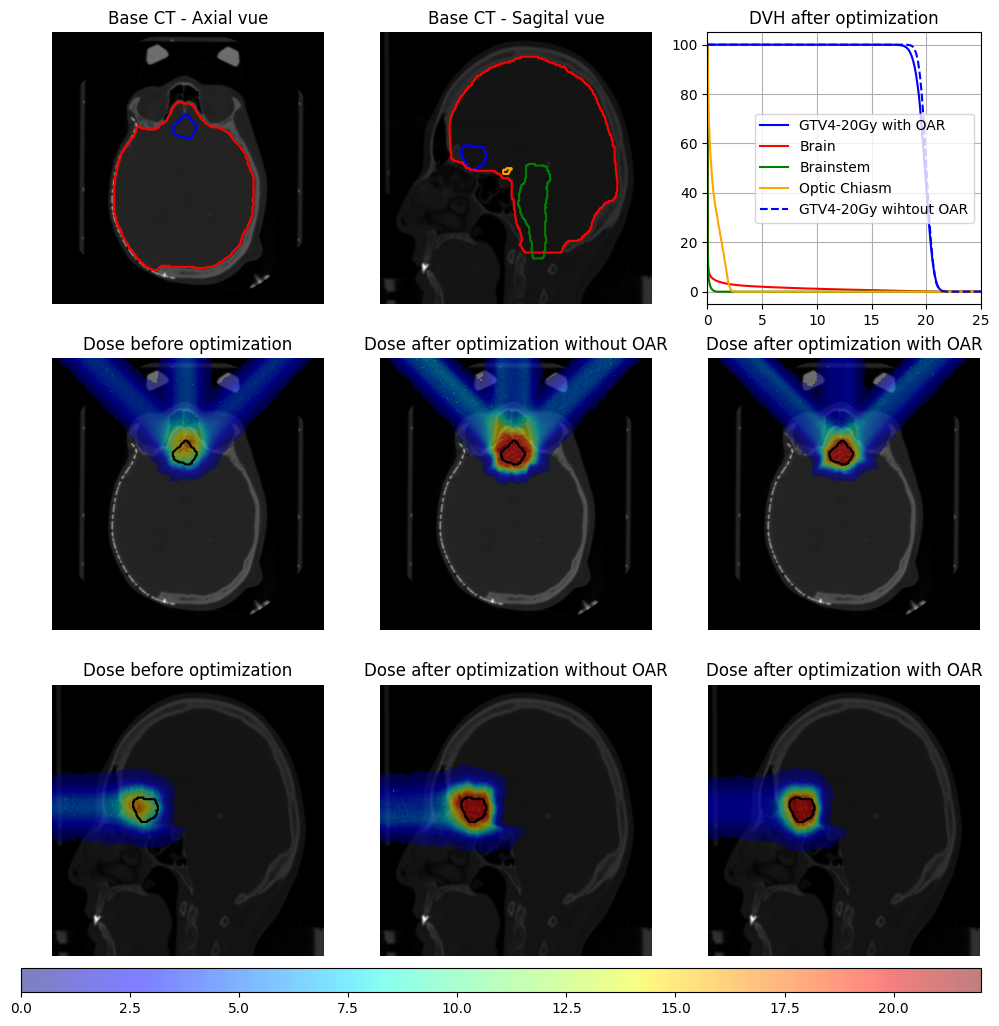

In [31]:
from skimage.transform import resize
image_ct_axial = ct.imageArray[:,:,Z_COORD].transpose(1,0)
image_target_axial = target.imageArray[:,:,Z_COORD].transpose(1,0)
image_brain_axial = OAR_brain.imageArray[:,:,Z_COORD].transpose(1,0)
image_brainstem_axial = OAR_brainstem.imageArray[:,:,Z_COORD].transpose(1,0)
image_optic_chiasm_axial = OAR_optic_chiasm.imageArray[:,:,Z_COORD].transpose(1,0)
image_dose_before_opti_axial = dose_before_opti.imageArray[:,:,Z_COORD].transpose(1,0)
image_dose_opti_axial = doseImage_opti.imageArray[:,:,Z_COORD].transpose(1,0)
image_dose_opti_OAR_axial = doseImage_opti_OAR.imageArray[:,:,Z_COORD].transpose(1,0)

# Check for NaN values
images = [dose_before_opti.imageArray,doseImage_opti.imageArray,doseImage_opti_OAR.imageArray]
doses_converted = []
for img in images:
    if np.isnan(img).any():
        converted_img = np.nan_to_num(img)
        doses_converted.append(converted_img)

image_ct_sagital = resize(np.rot90(ct.imageArray[COM_index[0],:,:]),(ct.gridSize[:-1]))
image_target_sagital = resize(np.rot90(target.imageArray[COM_index[0],:,:]),(ct.gridSize[:-1]))
image_brain_sagital = resize(np.rot90(OAR_brain.imageArray[COM_index[0],:,:]),(ct.gridSize[:-1]))
image_brainstem_sagital = resize(np.rot90(OAR_brainstem.imageArray[COM_index[0],:,:]),(ct.gridSize[:-1]))
image_optic_chiasm_sagital = resize(np.rot90(OAR_optic_chiasm.imageArray[COM_index[0],:,:]),(ct.gridSize[:-1]))
image_dose_before_opti_sagital = resize(np.rot90(doses_converted[0][COM_index[0],:,:]),(ct.gridSize[:-1]))
image_dose_opti_sagital = resize(np.rot90(doses_converted[1][COM_index[0],:,:]),(ct.gridSize[:-1]))
image_dose_opti_OAR_sagital = resize(np.rot90(doses_converted[2][COM_index[0],:,:]),(ct.gridSize[:-1]))

min_dose_val = 0.1
image_dose_before_opti_axial[image_dose_before_opti_axial <= min_dose_val] = np.nan
image_dose_opti_axial[image_dose_opti_axial <= min_dose_val] = np.nan
image_dose_opti_OAR_axial[image_dose_opti_OAR_axial <= min_dose_val] = np.nan
image_dose_before_opti_sagital[image_dose_before_opti_sagital <= min_dose_val] = np.nan
image_dose_opti_sagital[image_dose_opti_sagital <= min_dose_val] = np.nan
image_dose_opti_OAR_sagital[image_dose_opti_OAR_sagital <= min_dose_val] = np.nan

vmin=0
vmax=22

fig, ax = plt.subplots(3,3,figsize=(12,12))

ax[0,0].imshow(image_ct_axial,cmap="gray")
ax[0,0].contour(image_target_axial,colors="blue")
ax[0,0].contour(image_brain_axial,colors="red")
ax[0,0].contour(image_brainstem_axial,colors="green")
ax[0,0].contour(image_optic_chiasm_axial,colors="orange")
ax[0,0].axis("off")
ax[0,0].set_title("Base CT - Axial vue")

ax[0,1].imshow(image_ct_sagital,cmap="gray")
ax[0,1].contour(image_target_sagital,colors="blue")
ax[0,1].contour(image_brain_sagital,colors="red")
ax[0,1].contour(image_brainstem_sagital,colors="green")
ax[0,1].contour(image_optic_chiasm_sagital,colors="orange")
ax[0,1].axis("off")
ax[0,1].set_title("Base CT - Sagital vue")

ax[0,2].plot(target_DVH.histogram[0],target_DVH.histogram[1],label=target_DVH.name + " with OAR",color="blue")
ax[0,2].plot(brain_DVH.histogram[0],brain_DVH.histogram[1],label=brain_DVH.name, color="red")
ax[0,2].plot(brainstem_DVH.histogram[0],brainstem_DVH.histogram[1],label=brainstem_DVH.name, color="green")
ax[0,2].plot(optic_chiasm_DVH.histogram[0],optic_chiasm_DVH.histogram[1],label=optic_chiasm_DVH.name, color="orange")
ax[0,2].plot(target_DVH_No_OAR.histogram[0],target_DVH_No_OAR.histogram[1],label=target_DVH.name + " wihtout OAR",color="blue",linestyle="dashed")
ax[0,2].set_xlim(0,25)
ax[0,2].grid(True)
ax[0,2].legend()
ax[0,2].set_title("DVH after optimization")

ax[1,0].imshow(image_ct_axial,cmap="gray")
dose_bar_ref = ax[1,0].imshow(image_dose_before_opti_axial,cmap="jet",alpha=.5,vmin=vmin,vmax=vmax)
ax[1,0].contour(image_target_axial,colors="black")
ax[1,0].set_title("Dose before optimization")
ax[1,0].axis("off")

ax[1,1].imshow(image_ct_axial,cmap="gray")
ax[1,1].imshow(image_dose_opti_axial,cmap="jet",alpha=.5,vmin=vmin,vmax=vmax)
ax[1,1].contour(image_target_axial,colors="black")
ax[1,1].set_title("Dose after optimization without OAR")
ax[1,1].axis("off")

ax[1,2].imshow(image_ct_axial,cmap="gray")
ax[1,2].imshow(image_dose_opti_OAR_axial,cmap="jet",alpha=.5,vmin=vmin,vmax=vmax)
ax[1,2].contour(image_target_axial,colors="black")
ax[1,2].set_title("Dose after optimization with OAR")
ax[1,2].axis("off")

ax[2,0].imshow(image_ct_sagital,cmap="gray")
ax[2,0].imshow(image_dose_before_opti_sagital,cmap="jet",alpha=.5,vmin=vmin,vmax=vmax)
ax[2,0].contour(image_target_sagital,colors="black")
ax[2,0].set_title("Dose before optimization")
ax[2,0].axis("off")

ax[2,1].imshow(image_ct_sagital,cmap="gray")
ax[2,1].imshow(image_dose_opti_sagital,cmap="jet",alpha=.5,vmin=vmin,vmax=vmax)
ax[2,1].contour(image_target_sagital,colors="black")
ax[2,1].set_title("Dose after optimization without OAR")
ax[2,1].axis("off")

ax[2,2].imshow(image_ct_sagital,cmap="gray")
ax[2,2].imshow(image_dose_opti_OAR_sagital,cmap="jet",alpha=.5,vmin=vmin,vmax=vmax)
ax[2,2].contour(image_target_sagital,colors="black")
ax[2,2].set_title("Dose after optimization with OAR")
ax[2,2].axis("off")
cb_ax = fig.add_axes([0.1, 0.08, 0.8, 0.02])
fig.colorbar(dose_bar_ref,cax=cb_ax,location="bottom")
plt.savefig(os.path.join(output_path, "SimpleRealDoseComputationOptimization_output.png"))
plt.show()
plt.close()

![png](/assets/img_notebooks/SimpleRealDoseComputationOptimization_output.png)